<a href="https://colab.research.google.com/github/laume/airline_sentments/blob/master/NLP_airline_negativereason.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](https://storage.googleapis.com/kaggle-datasets-images/36308/54852/c377118a238f7584f561b5a6fd37d303/dataset-cover.jpg?t=2018-07-12-20-05-21)
## Airline sentiment tweets
## U.S Airline Tweets for sentiment analysis

https://www.kaggle.com/tango911/airline-sentiment-tweets

## Prepare environment

### Setup Kaggle variables:

In [0]:
SETUP = True
KAGGLE = True
COMPETITION = 'kaggle datasets download -d tango911/airline-sentiment-tweets'
DATA_DIR = 'data/airlines'
UNARCHIVE_DATA = False

### Install libraries and perform setup

In [0]:
if SETUP:
    !pip install --upgrade --quiet dlai
    !pip install -q -U toai
    !pip install -q -U nb_black
    !pip install -q -U tensorflow-datasets
    !pip install -q -U --no-deps tensorflow-addons~=0.6
    print(__import__("toai").__version__)
    print(f'dlai version: {__import__("dlai").__version__}, tf version: {__import__("tensorflow").__version__}')

     |████████████████████████████████| 380.8MB 44kB/s 
     |████████████████████████████████| 3.8MB 43.5MB/s 
     |████████████████████████████████| 450kB 51.2MB/s 
     |████████████████████████████████| 81kB 12.5MB/s 
ERROR: tensorflow 1.15.0 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 2.0.1 which is incompatible.
ERROR: tensorflow 1.15.0 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 2.0.1 which is incompatible.
ERROR: tensorboard 2.0.1 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.7.1 which is incompatible.
     |████████████████████████████████| 81kB 10.5MB/s 
     |████████████████████████████████| 153kB 45.7MB/s 
     |████████████████████████████████| 296kB 56.3MB/s 
     |████████████████████████████████| 61kB 9.0MB/s 
     |████████████████████████████████| 102kB 11.9MB/s 
     |█

In [0]:
import dlai
from dlai.imports import *
from toai.imports import *
from toai.data import DataBundle, DataParams, DataContainer
from toai.metrics import sparse_top_2_categorical_accuracy
import tensorflow as tf
from tensorflow import keras
import tensorflow_addons as tfa
import tensorflow_datasets as tfds

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/toai/imports.py:70: UserWarning: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.
  warnings.warn(str(error))


In [0]:
%load_ext autoreload
%autoreload 2

In [0]:
%matplotlib inline

In [0]:
if KAGGLE:
    setup_kaggle()
    download_kaggle_data(COMPETITION, DATA_DIR)

In [0]:
!ls {DATA_DIR}

train.csv


In [0]:
DATA_DIR = Path(DATA_DIR)

## Explore the data

In [0]:
df = pd.read_csv(DATA_DIR/'train.csv')

In [0]:
df.head(3).T

,0,1,2
tweet_id,Tr_tweet_1,Tr_tweet_2,Tr_tweet_3
airline_sentiment,neutral,positive,neutral
airline_sentiment_confidence,1,0.3486,0.6837
negativereason,NaN,NaN,NaN
negativereason_confidence,NaN,0,NaN
airline,Virgin America,Virgin America,Virgin America
name,cairdin,jnardino,yvonnalynn
retweet_count,0,0,0
text,@VirginAmerica What @dhepburn said.,@VirginAmerica plus you've added commercials t...,@VirginAmerica I didn't today... Must mean I n...
tweet_created,2015-02-24 11:35:52 -0800,2015-02-24 11:15:59 -0800,2015-02-24 11:15:48 -0800


In [0]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
tweet_id,3339,3339,Tr_tweet_3063,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
airline_sentiment,3339,3,negative,2135,NaN,NaN,NaN,NaN,NaN,NaN,NaN
airline_sentiment_confidence,3339,NaN,NaN,NaN,0.896748,0.165675,0.335,0.68895,1,1,1
negativereason,2134,10,Customer Service Issue,563,NaN,NaN,NaN,NaN,NaN,NaN,NaN
negativereason_confidence,2450,NaN,NaN,NaN,0.618021,0.326748,0,0.355525,0.66685,1,1
airline,3338,2,United,2884,NaN,NaN,NaN,NaN,NaN,NaN,NaN
name,3338,1925,throthra,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
retweet_count,3338,NaN,NaN,NaN,0.106052,0.350716,0,0,0,0,4
text,3338,3321,@united thanks,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tweet_created,3243,3227,2015-02-23 06:57:24 -0800,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3339 entries, 0 to 3338
Data columns (total 12 columns):
tweet_id                        3339 non-null object
airline_sentiment               3339 non-null object
airline_sentiment_confidence    3339 non-null float64
negativereason                  2134 non-null object
negativereason_confidence       2450 non-null float64
airline                         3338 non-null object
name                            3338 non-null object
retweet_count                   3338 non-null float64
text                            3338 non-null object
tweet_created                   3243 non-null object
tweet_location                  2319 non-null object
user_timezone                   2231 non-null object
dtypes: float64(3), object(9)
memory usage: 313.2+ KB


In [0]:
df.airline.value_counts()

United            2884
Virgin America     454
Name: airline, dtype: int64

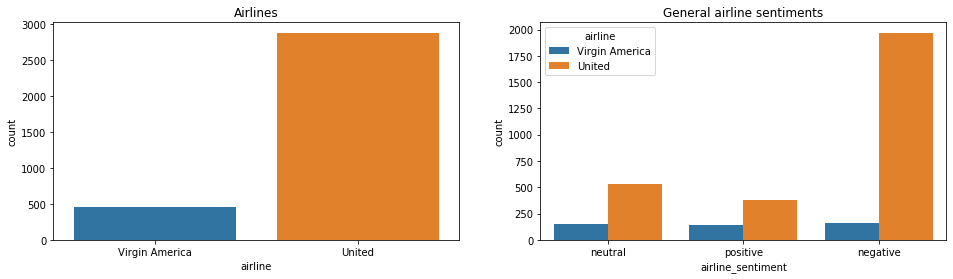

In [0]:
f, ax = plt.subplots(1, 2, figsize=(16, 4))
sns.countplot(df.airline, ax=ax[0]).set_title('Airlines');
sns.countplot(x = 'airline_sentiment', hue='airline', data= df, ax=ax[1]).set_title('General airline sentiments');

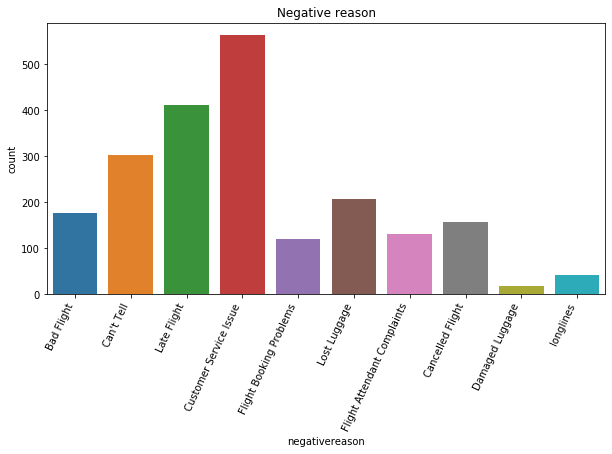

In [0]:
plt.figure(figsize=(10,5))
sns.countplot(df.negativereason).set_title('Negative reason');
plt.xticks(rotation=65, horizontalalignment='right');

In [0]:
def make_category_map(labels):
    return {x: i for i, x in enumerate(set(labels))}

### Select negatives only

In [0]:
negatives = df[df.airline_sentiment == 'negative']
negatives = negatives[['text', 'negativereason']]
len(df), len(negatives)

(3339, 2135)

In [0]:
negatives.tail(3)

,text,negativereason
3336,@united I will be patient as your agent explai...,Flight Booking Problems
3337,@united please help trace my luggage which was...,Lost Luggage
3338,NaN,NaN


In [0]:
negatives.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2135 entries, 3 to 3338
Data columns (total 2 columns):
text              2134 non-null object
negativereason    2134 non-null object
dtypes: object(2)
memory usage: 50.0+ KB


In [0]:
negatives = negatives[~negatives["text"].isna()]
len(negatives)

2134

In [0]:
category_map = make_category_map(negatives["negativereason"].values)
category_map

{'Bad Flight': 5,
 "Can't Tell": 4,
 'Cancelled Flight': 1,
 'Customer Service Issue': 7,
 'Damaged Luggage': 3,
 'Flight Attendant Complaints': 0,
 'Flight Booking Problems': 2,
 'Late Flight': 9,
 'Lost Luggage': 6,
 'longlines': 8}

In [0]:
n_categories = len(category_map)
n_categories

10

In [0]:
negatives["negativereason"] = negatives["negativereason"].map(category_map)

In [0]:
negatives.tail(3)

,text,negativereason
3335,@united I will be patient in my luxurious midd...,9
3336,@united I will be patient as your agent explai...,2
3337,@united please help trace my luggage which was...,6


# Preprocessing

In [0]:
data_container = DataContainer(
    *DataBundle.split(
        data_bundle=DataBundle.from_dataframe(
            dataframe=negatives, x_col="text", y_col="negativereason"
        ),
        fracs=[0.9, 0.1, 0],
    )
)

In [0]:
class_weights = dict(
    enumerate(
        sk.utils.class_weight.compute_class_weight(
            "balanced", np.unique(data_container.train.y), data_container.train.y
        )
    )
)

In [0]:
class_weights

{0: 1.6279661016949152,
 1: 1.2721854304635762,
 2: 1.7306306306306307,
 3: 12.806666666666667,
 4: 0.7114814814814815,
 5: 1.1642424242424243,
 6: 1.0554945054945055,
 7: 0.37889546351084813,
 8: 4.925641025641026,
 9: 0.5292011019283747}

In [0]:
len(data_container.train), len(data_container.validation), len(data_container.test)

(1921, 213, 0)

In [0]:
def make_dataset(data_bundle):
    return tf.data.Dataset.from_tensor_slices((data_bundle.x, data_bundle.y))

In [0]:
data_container.train.dataset = make_dataset(data_container.train)
data_container.validation.dataset = make_dataset(data_container.validation)
# data_container.test.dataset = make_dataset(data_container.test)

In [0]:
data_container.train.x[1]

'@United says we had a weather delay in #YXE this morning. The "weather" didn\'t affect any other airline. #UA6136 http://t.co/4JdvK8tCqx'

In [0]:
[key for key, val in category_map.items() if val == data_container.train.y[1]]

['Late Flight']

In [0]:
def preprocess(x, y, max_length=50):
    x = tf.strings.regex_replace(x, b"^@[a-zA-Z]+", b" ")
    x = tf.strings.regex_replace(x, rb"<br\s*/?>", b" ")
    x = tf.strings.regex_replace(x, b"[^a-zA-Z']", b" ")
    x = tf.strings.split(x)
    x = x[:, :max_length]
    return x.to_tensor(default_value=b"<pad>"), y

In [0]:
BATCH_SIZE = 32

In [0]:
for x, y in data_container.train.dataset.batch(BATCH_SIZE).map(preprocess).take(1):
    print(x.shape)
    print(y.shape)
    print(x[1])
    print(y[1])

(32, 27)
(32,)
tf.Tensor(
[b'says' b'we' b'had' b'a' b'weather' b'delay' b'in' b'YXE' b'this'
 b'morning' b'The' b'weather' b"didn't" b'affect' b'any' b'other'
 b'airline' b'UA' b'http' b't' b'co' b'JdvK' b'tCqx' b'<pad>' b'<pad>'
 b'<pad>' b'<pad>'], shape=(27,), dtype=string)
tf.Tensor(9, shape=(), dtype=int64)


In [0]:
def make_vocabulary(dataset):
    vocabulary = Counter()
    for x, _ in dataset.batch(BATCH_SIZE).map(preprocess):
        for review in x:
            vocabulary.update(review.numpy().tolist())
    return vocabulary

In [0]:
vocabulary = make_vocabulary(data_container.train.dataset)

In [0]:
vocabulary.most_common()[:15]

[(b'<pad>', 17428),
 (b'to', 1178),
 (b'the', 823),
 (b'a', 706),
 (b'I', 679),
 (b'and', 549),
 (b'you', 504),
 (b'for', 502),
 (b'on', 501),
 (b'my', 483),
 (b'flight', 463),
 (b'is', 426),
 (b'in', 398),
 (b'of', 321),
 (b'your', 273)]

In [0]:
len(vocabulary)

4931

In [0]:
VOCABULARY_SIZE = 3000

In [0]:
truncated_vocabulary = [
    word for word, count in vocabulary.most_common()[:VOCABULARY_SIZE]
]

In [0]:
len(truncated_vocabulary)

3000

In [0]:
word_to_id = {word: index for index, word in enumerate(truncated_vocabulary)}

In [0]:
for word in b"it is fun to travel by boat".split():
    print(word_to_id.get(word) or VOCABULARY_SIZE)

16
11
1211
1
284
103
3000


In [0]:
words = tf.constant(truncated_vocabulary)

In [0]:
word_ids = tf.range(len(truncated_vocabulary), dtype=tf.int64)

In [0]:
vocab_init = tf.lookup.KeyValueTensorInitializer(words, word_ids)

In [0]:
n_oov_buckets = VOCABULARY_SIZE // 10
n_oov_buckets

300

In [0]:
table = tf.lookup.StaticVocabularyTable(vocab_init, n_oov_buckets)

In [0]:
table.lookup(tf.constant([b"it is fun to travel by boat".split()]))

<tf.Tensor: id=89510, shape=(1, 7), dtype=int64, numpy=array([[  16,   11, 1211,    1,  284,  103, 3225]])>

In [0]:
def encode_words(x, y):
    return table.lookup(x), y

In [0]:
def encode_categories(x, y):
    return table.lookup(x), y

In [0]:
train_dataset = (
    data_container.train.dataset.repeat()
    .batch(BATCH_SIZE)
    .map(preprocess)
    .map(encode_words)
    .prefetch(-1)
)

In [0]:
validation_dataset = (
    data_container.validation.dataset.batch(BATCH_SIZE)
    .map(preprocess)
    .map(encode_words)
)

In [0]:
for x, y in train_dataset.take(1):
    print(x.shape)
    print(y.shape)
    print(x[1])
    print(y[1])

(32, 27)
(32,)
tf.Tensor(
[ 319   35   76    3  222   94   12 2191   27  428  196  222  161 2192
  172  173   64   45   51   41   47 2193 2194    0    0    0    0], shape=(27,), dtype=int64)
tf.Tensor(9, shape=(), dtype=int64)


In [0]:
for x, y in validation_dataset.take(1):
    print(x.shape)
    print(y.shape)
    print(x[0])
    print(y[0])

(32, 27)
(32,)
tf.Tensor(
[ 309 3005   55   21  100 1171   13 1011  859  243   87  119  755   48
  279  401  109   33  205   69    0    0    0    0    0    0    0], shape=(27,), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)


In [0]:
train_dataset_steps = len(data_container.train) // BATCH_SIZE

In [0]:
validation_dataset_steps = len(data_container.validation) // BATCH_SIZE

# Create Models

## Bidirectional LSTM model

In [0]:
def make_sequential_lstm_model(
    n_categories, embedding_size, lstm_size, lstm_dropout, dropout
):
    return keras.models.Sequential(
        [
            keras.layers.Embedding(
                VOCABULARY_SIZE + n_oov_buckets,
                embedding_size,
                mask_zero=True,
                input_shape=[None],
            ),
            keras.layers.Bidirectional(
                keras.layers.LSTM(
                    lstm_size, dropout=lstm_dropout, return_sequences=True
                )
            ),
            keras.layers.Bidirectional(
                keras.layers.LSTM(
                    lstm_size, dropout=lstm_dropout, return_sequences=True
                )
            ),
            keras.layers.GlobalMaxPool1D(),
            keras.layers.Dropout(dropout),
            keras.layers.Dense(n_categories, activation=keras.activations.softmax),
        ]
    )

In [0]:
model = make_sequential_lstm_model(
    n_categories=n_categories,
    embedding_size=32,
    lstm_size=32,
    lstm_dropout=0.2,
    dropout=0.5,
)

In [0]:
model.compile(
    loss=keras.losses.sparse_categorical_crossentropy,
    optimizer=keras.optimizers.Adam(lr=3e-4),
    metrics=[
        keras.metrics.sparse_categorical_accuracy,
        sparse_top_2_categorical_accuracy,
    ],
)

In [0]:
history = model.fit(
    train_dataset,
    steps_per_epoch=train_dataset_steps,
    validation_data=validation_dataset,
    validation_steps=validation_dataset_steps,
    epochs=15,
    callbacks=[
        keras.callbacks.ReduceLROnPlateau(patience=4, factor=0.3),
        keras.callbacks.EarlyStopping(patience=4, restore_best_weights=True),
    ],
    class_weight=class_weights,
)

Train for 60 steps, validate for 6 steps
Epoch 1/15
60/60 [==============================] - 20s 340ms/step - loss: 2.2685 - sparse_categorical_accuracy: 0.2458 - sparse_top_2_categorical_accuracy: 0.4083 - val_loss: 2.1846 - val_sparse_categorical_accuracy: 0.2604 - val_sparse_top_2_categorical_accuracy: 0.4896
Epoch 2/15
60/60 [==============================] - 3s 49ms/step - loss: 2.1331 - sparse_categorical_accuracy: 0.2542 - sparse_top_2_categorical_accuracy: 0.4479 - val_loss: 2.0520 - val_sparse_categorical_accuracy: 0.2604 - val_sparse_top_2_categorical_accuracy: 0.4896
Epoch 3/15
60/60 [==============================] - 3s 50ms/step - loss: 2.0859 - sparse_categorical_accuracy: 0.2536 - sparse_top_2_categorical_accuracy: 0.4484 - val_loss: 2.0311 - val_sparse_categorical_accuracy: 0.2604 - val_sparse_top_2_categorical_accuracy: 0.4896
Epoch 4/15
60/60 [==============================] - 3s 48ms/step - loss: 2.0524 - sparse_categorical_accuracy: 0.2589 - sparse_top_2_categorical

In [0]:
model.evaluate(validation_dataset, steps=validation_dataset_steps)

6/6 [==============================] - 0s 13ms/step - loss: 1.9373 - sparse_categorical_accuracy: 0.3906 - sparse_top_2_categorical_accuracy: 0.5000


[1.9372918009757996, 0.390625, 0.5]

In [0]:
print(
    classification_report(
        data_container.validation.y, model.predict(validation_dataset).argmax(axis=1)
    )
)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        14
           1       0.21      0.71      0.32         7
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00         3
           4       0.20      0.32      0.25        34
           5       0.00      0.00      0.00        12
           6       0.00      0.00      0.00        25
           7       0.62      0.59      0.61        56
           8       0.00      0.00      0.00         3
           9       0.39      0.65      0.49        49

    accuracy                           0.38       213
   macro avg       0.14      0.23      0.17       213
weighted avg       0.29      0.38      0.32       213



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


As validation loss not improving at all, try to make architecture more simplier, and try to use smaller LR and more regularization.




In [0]:
def make_sequential_lstm_model_2(
    n_categories, embedding_size, lstm_size, lstm_dropout, dropout, l1=1e-8, l2=1e-8,
):
    return keras.models.Sequential(
        [
            keras.layers.Embedding(
                VOCABULARY_SIZE + n_oov_buckets,
                embedding_size,
                mask_zero=True,
                input_shape=[None],
            ),
            keras.layers.Bidirectional(
                keras.layers.LSTM(
                    lstm_size, dropout=lstm_dropout, return_sequences=True
                )
            ),
            keras.layers.GlobalMaxPool1D(),
            keras.layers.Dropout(dropout),
            keras.layers.Dense(
                n_categories, 
                activation=keras.activations.softmax,
                kernel_regularizer=keras.regularizers.l1_l2(l1, l2)
            ),
        ]
    )

In [0]:
model_2 = make_sequential_lstm_model_2(
    n_categories=n_categories,
    embedding_size=64,
    lstm_size=64,
    lstm_dropout=0.2,
    dropout=0.5,
    l1=1e-8,
    l2=1e-8,
)

In [0]:
model_2.compile(
    loss=keras.losses.sparse_categorical_crossentropy,
    optimizer=keras.optimizers.Adam(lr=1e-5),
    metrics=[
        keras.metrics.sparse_categorical_accuracy,
        sparse_top_2_categorical_accuracy,
    ],
)

In [0]:
history_2 = model_2.fit(
    train_dataset,
    steps_per_epoch=train_dataset_steps,
    validation_data=validation_dataset,
    validation_steps=validation_dataset_steps,
    epochs=20,
    callbacks=[
        keras.callbacks.ReduceLROnPlateau(patience=4, factor=0.3),
        keras.callbacks.EarlyStopping(patience=6, restore_best_weights=True),
    ],
    class_weight=class_weights,
)

Train for 60 steps, validate for 6 steps
Epoch 1/20
60/60 [==============================] - 12s 198ms/step - loss: 2.3022 - sparse_categorical_accuracy: 0.0901 - sparse_top_2_categorical_accuracy: 0.2005 - val_loss: 2.3014 - val_sparse_categorical_accuracy: 0.0833 - val_sparse_top_2_categorical_accuracy: 0.1927
Epoch 2/20
60/60 [==============================] - 2s 41ms/step - loss: 2.2999 - sparse_categorical_accuracy: 0.1068 - sparse_top_2_categorical_accuracy: 0.2193 - val_loss: 2.2993 - val_sparse_categorical_accuracy: 0.1042 - val_sparse_top_2_categorical_accuracy: 0.2188
Epoch 3/20
60/60 [==============================] - 2s 40ms/step - loss: 2.2988 - sparse_categorical_accuracy: 0.1094 - sparse_top_2_categorical_accuracy: 0.2208 - val_loss: 2.2972 - val_sparse_categorical_accuracy: 0.1302 - val_sparse_top_2_categorical_accuracy: 0.2760
Epoch 4/20
60/60 [==============================] - 3s 42ms/step - loss: 2.2969 - sparse_categorical_accuracy: 0.1255 - sparse_top_2_categorical

In [0]:
model_2.evaluate(validation_dataset, steps=validation_dataset_steps)

6/6 [==============================] - 0s 11ms/step - loss: 2.2534 - sparse_categorical_accuracy: 0.2917 - sparse_top_2_categorical_accuracy: 0.4948


[2.2533832788467407, 0.29166666, 0.49479166]

In [0]:
print(
    classification_report(
        data_container.validation.y, model_2.predict(validation_dataset).argmax(axis=1)
    )
)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        14
           1       0.00      0.00      0.00         7
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00        34
           5       0.00      0.00      0.00        12
           6       0.00      0.00      0.00        25
           7       0.27      0.62      0.38        56
           8       0.00      0.00      0.00         3
           9       0.33      0.55      0.41        49

    accuracy                           0.29       213
   macro avg       0.06      0.12      0.08       213
weighted avg       0.15      0.29      0.19       213



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [0]:
model_3 = make_sequential_lstm_model_2(
    n_categories=n_categories,
    embedding_size=64,
    lstm_size=64,
    lstm_dropout=0.2,
    dropout=0.5,
    l1=3e-6,
    l2=3e-4,
)

In [0]:
model_3.compile(
    loss=keras.losses.sparse_categorical_crossentropy,
    optimizer=keras.optimizers.Adam(lr=1e-5),
    metrics=[
        keras.metrics.sparse_categorical_accuracy,
        sparse_top_2_categorical_accuracy,
    ],
)

In [0]:
history_3 = model_3.fit(
    train_dataset,
    steps_per_epoch=train_dataset_steps,
    validation_data=validation_dataset,
    validation_steps=validation_dataset_steps,
    epochs=20,
    callbacks=[
        keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.3),
        keras.callbacks.EarlyStopping(patience=6, restore_best_weights=True),
    ],
    class_weight=class_weights_2,
)

Train for 81 steps, validate for 10 steps
Epoch 1/20
81/81 [==============================] - 12s 147ms/step - loss: 1.1001 - sparse_categorical_accuracy: 0.2820 - sparse_top_2_categorical_accuracy: 0.7458 - val_loss: 1.0980 - val_sparse_categorical_accuracy: 0.2000 - val_sparse_top_2_categorical_accuracy: 0.7937
Epoch 2/20
81/81 [==============================] - 3s 41ms/step - loss: 1.0956 - sparse_categorical_accuracy: 0.3769 - sparse_top_2_categorical_accuracy: 0.7793 - val_loss: 1.0935 - val_sparse_categorical_accuracy: 0.5500 - val_sparse_top_2_categorical_accuracy: 0.7937
Epoch 3/20
81/81 [==============================] - 3s 41ms/step - loss: 1.0906 - sparse_categorical_accuracy: 0.5062 - sparse_top_2_categorical_accuracy: 0.7894 - val_loss: 1.0889 - val_sparse_categorical_accuracy: 0.6313 - val_sparse_top_2_categorical_accuracy: 0.7937
Epoch 4/20
81/81 [==============================] - 3s 40ms/step - loss: 1.0860 - sparse_categorical_accuracy: 0.5833 - sparse_top_2_categorica

In [0]:
model_3.evaluate(validation_dataset, steps=validation_dataset_steps)

10/10 [==============================] - 0s 10ms/step - loss: 0.8400 - sparse_categorical_accuracy: 0.6344 - sparse_top_2_categorical_accuracy: 0.8375


[0.8400044322013855, 0.634375, 0.8375]

In [0]:
print(
    classification_report(
        data_container.validation.y, model_3.predict(validation_dataset).argmax(axis=1)
    )
)

              precision    recall  f1-score   support

           0       0.64      1.00      0.78       209
           1       0.00      0.00      0.00        54
           2       0.00      0.00      0.00        65

    accuracy                           0.64       328
   macro avg       0.21      0.33      0.26       328
weighted avg       0.41      0.64      0.50       328



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [0]:
class_weights_2 = {0: 1, 1: 1, 2: 0}

In [0]:
model_3 = make_sequential_lstm_model_2(
    n_categories=n_categories,
    embedding_size=256,
    lstm_size=256,
    lstm_dropout=0.2,
    dropout=0.5,
    l1=3e-6,
    l2=3e-4,
)

In [0]:
model_3.compile(
    loss=keras.losses.sparse_categorical_crossentropy,
    optimizer=keras.optimizers.Adam(lr=3e-5),
    metrics=[
        keras.metrics.sparse_categorical_accuracy,
        sparse_top_2_categorical_accuracy,
    ],
)

In [0]:
class_weights_2

{0: 1, 1: 1, 2: 0}

In [0]:
history_3 = model_3.fit(
    train_dataset,
    steps_per_epoch=train_dataset_steps,
    validation_data=validation_dataset,
    validation_steps=validation_dataset_steps,
    epochs=20,
    callbacks=[
        keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.3),
        keras.callbacks.EarlyStopping(patience=6, restore_best_weights=True),
    ],
    # class_weight=class_weights_2,
    class_weight=[1, 1, 0],
)

Train for 81 steps, validate for 10 steps
Epoch 1/20
81/81 [==============================] - 40s 495ms/step - loss: 1.0766 - sparse_categorical_accuracy: 0.6061 - sparse_top_2_categorical_accuracy: 0.8148 - val_loss: 1.0495 - val_sparse_categorical_accuracy: 0.6875 - val_sparse_top_2_categorical_accuracy: 0.8687
Epoch 2/20
81/81 [==============================] - 29s 364ms/step - loss: 1.0105 - sparse_categorical_accuracy: 0.6373 - sparse_top_2_categorical_accuracy: 0.8507 - val_loss: 0.8577 - val_sparse_categorical_accuracy: 0.6875 - val_sparse_top_2_categorical_accuracy: 0.8656
Epoch 3/20
81/81 [==============================] - 29s 359ms/step - loss: 0.8473 - sparse_categorical_accuracy: 0.6385 - sparse_top_2_categorical_accuracy: 0.8468 - val_loss: 0.7553 - val_sparse_categorical_accuracy: 0.6875 - val_sparse_top_2_categorical_accuracy: 0.8656
Epoch 4/20
81/81 [==============================] - 29s 355ms/step - loss: 0.8265 - sparse_categorical_accuracy: 0.6377 - sparse_top_2_cate

KeyboardInterrupt: ignored

In [0]:
model_3.evaluate(validation_dataset, steps=validation_dataset_steps)

10/10 [==============================] - 1s 93ms/step - loss: 0.7354 - sparse_categorical_accuracy: 0.6875 - sparse_top_2_categorical_accuracy: 0.8656


[0.7354410052299499, 0.6875, 0.865625]

In [0]:
print(
    classification_report(
        data_container.validation.y, model_3.predict(validation_dataset).argmax(axis=1)
    )
)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        60
           1       0.00      0.00      0.00        45
           2       0.68      1.00      0.81       223

    accuracy                           0.68       328
   macro avg       0.23      0.33      0.27       328
weighted avg       0.46      0.68      0.55       328



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Try to run model without class weights

In [0]:
model_4 = make_sequential_lstm_model_2(
    n_categories=n_categories,
    embedding_size=256,
    lstm_size=256,
    lstm_dropout=0.2,
    dropout=0.3,
    l1=1e-8,
    l2=1e-8,
)

In [0]:
model_4.compile(
    loss=keras.losses.sparse_categorical_crossentropy,
    optimizer=keras.optimizers.Adam(lr=3e-5),
    metrics=[
        keras.metrics.sparse_categorical_accuracy,
        sparse_top_2_categorical_accuracy,
    ],
)

In [0]:
history_4 = model_4.fit(
    train_dataset,
    steps_per_epoch=train_dataset_steps,
    validation_data=validation_dataset,
    validation_steps=validation_dataset_steps,
    epochs=10,
    callbacks=[
        keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.3),
        keras.callbacks.EarlyStopping(patience=6, restore_best_weights=True),
    ],
)

Train for 81 steps, validate for 10 steps
Epoch 1/10
81/81 [==============================] - 33s 409ms/step - loss: 1.0707 - sparse_categorical_accuracy: 0.6323 - sparse_top_2_categorical_accuracy: 0.8407 - val_loss: 1.0498 - val_sparse_categorical_accuracy: 0.6344 - val_sparse_top_2_categorical_accuracy: 0.8375
Epoch 2/10
81/81 [==============================] - 25s 303ms/step - loss: 0.9845 - sparse_categorical_accuracy: 0.6443 - sparse_top_2_categorical_accuracy: 0.8430 - val_loss: 0.8430 - val_sparse_categorical_accuracy: 0.6344 - val_sparse_top_2_categorical_accuracy: 0.8344
Epoch 3/10
81/81 [==============================] - 24s 299ms/step - loss: 0.8311 - sparse_categorical_accuracy: 0.6439 - sparse_top_2_categorical_accuracy: 0.8515 - val_loss: 0.8260 - val_sparse_categorical_accuracy: 0.6344 - val_sparse_top_2_categorical_accuracy: 0.8375
Epoch 4/10
81/81 [==============================] - 24s 298ms/step - loss: 0.8102 - sparse_categorical_accuracy: 0.6451 - sparse_top_2_cate

In [0]:
model_4.evaluate(validation_dataset, steps=validation_dataset_steps)

10/10 [==============================] - 1s 79ms/step - loss: 0.8356 - sparse_categorical_accuracy: 0.6469 - sparse_top_2_categorical_accuracy: 0.8656


[0.835593044757843, 0.646875, 0.865625]

In [0]:
print(
    classification_report(
        data_container.validation.y, model_4.predict(validation_dataset).argmax(axis=1)
    )
)

              precision    recall  f1-score   support

           0       0.70      0.95      0.81       209
           1       1.00      0.02      0.04        54
           2       0.30      0.20      0.24        65

    accuracy                           0.65       328
   macro avg       0.67      0.39      0.36       328
weighted avg       0.67      0.65      0.57       328



In [0]:
np.bincount(data_container.validation.y)

array([209,  54,  65])

Use less neurons

In [0]:
model_4 = make_sequential_lstm_model_2(
    n_categories=n_categories,
    embedding_size=32,
    lstm_size=32,
    lstm_dropout=0.2,
    dropout=0.5,
    l1=1e-8,
    l2=1e-8,
)

In [0]:
model_4.compile(
    loss=keras.losses.sparse_categorical_crossentropy,
    optimizer=keras.optimizers.Adam(lr=3e-4),
    metrics=[
        keras.metrics.sparse_categorical_accuracy,
        sparse_top_2_categorical_accuracy,
    ],
)

In [0]:
history_4 = model_4.fit(
    train_dataset,
    steps_per_epoch=train_dataset_steps,
    validation_data=validation_dataset,
    validation_steps=validation_dataset_steps,
    epochs=10,
    callbacks=[
        keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.3),
        keras.callbacks.EarlyStopping(patience=4, restore_best_weights=True),
    ],
    class_weight=class_weights,
)

Train for 81 steps, validate for 10 steps
Epoch 1/10
81/81 [==============================] - 13s 158ms/step - loss: 1.0175 - sparse_categorical_accuracy: 0.6142 - sparse_top_2_categorical_accuracy: 0.8218 - val_loss: 0.8397 - val_sparse_categorical_accuracy: 0.6344 - val_sparse_top_2_categorical_accuracy: 0.8500
Epoch 2/10
81/81 [==============================] - 2s 27ms/step - loss: 0.8325 - sparse_categorical_accuracy: 0.6443 - sparse_top_2_categorical_accuracy: 0.8499 - val_loss: 0.8152 - val_sparse_categorical_accuracy: 0.6344 - val_sparse_top_2_categorical_accuracy: 0.8438
Epoch 3/10
81/81 [==============================] - 2s 27ms/step - loss: 0.7898 - sparse_categorical_accuracy: 0.6443 - sparse_top_2_categorical_accuracy: 0.8519 - val_loss: 0.7805 - val_sparse_categorical_accuracy: 0.6375 - val_sparse_top_2_categorical_accuracy: 0.8531
Epoch 4/10
81/81 [==============================] - 2s 27ms/step - loss: 0.6817 - sparse_categorical_accuracy: 0.6728 - sparse_top_2_categorica

In [0]:
print(
    classification_report(
        data_container.validation.y, model_4.predict(validation_dataset).argmax(axis=1)
    )
)

              precision    recall  f1-score   support

           0       0.70      1.00      0.82       209
           1       1.00      0.09      0.17        54
           2       0.46      0.17      0.25        65

    accuracy                           0.68       328
   macro avg       0.72      0.42      0.41       328
weighted avg       0.70      0.68      0.60       328



In [0]:
model_4 = make_sequential_lstm_model_2(
    n_categories=n_categories,
    embedding_size=32,
    lstm_size=32,
    lstm_dropout=0.3,
    dropout=0.5,
    l1=1e-8,
    l2=1e-8,
)

In [0]:
model_4.compile(
    loss=keras.losses.sparse_categorical_crossentropy,
    optimizer=keras.optimizers.SGD(lr=3e-5),
    metrics=[
        keras.metrics.sparse_categorical_accuracy,
        sparse_top_2_categorical_accuracy,
    ],
)

In [0]:
history_4 = model_4.fit(
    train_dataset,
    steps_per_epoch=train_dataset_steps,
    validation_data=validation_dataset,
    validation_steps=validation_dataset_steps,
    epochs=10,
    callbacks=[
        keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.3),
        keras.callbacks.EarlyStopping(patience=4, restore_best_weights=True),
    ],
    class_weight=class_weights,
)

Train for 81 steps, validate for 10 steps
Epoch 1/10
81/81 [==============================] - 13s 165ms/step - loss: 1.1013 - sparse_categorical_accuracy: 0.2851 - sparse_top_2_categorical_accuracy: 0.6130 - val_loss: 1.1003 - val_sparse_categorical_accuracy: 0.2375 - val_sparse_top_2_categorical_accuracy: 0.5688
Epoch 2/10
81/81 [==============================] - 2s 24ms/step - loss: 1.0998 - sparse_categorical_accuracy: 0.3175 - sparse_top_2_categorical_accuracy: 0.6609 - val_loss: 1.0993 - val_sparse_categorical_accuracy: 0.3031 - val_sparse_top_2_categorical_accuracy: 0.6344
Epoch 3/10
81/81 [==============================] - 2s 24ms/step - loss: 1.0993 - sparse_categorical_accuracy: 0.3245 - sparse_top_2_categorical_accuracy: 0.6620 - val_loss: 1.0983 - val_sparse_categorical_accuracy: 0.3625 - val_sparse_top_2_categorical_accuracy: 0.7031
Epoch 4/10
81/81 [==============================] - 2s 24ms/step - loss: 1.0981 - sparse_categorical_accuracy: 0.3499 - sparse_top_2_categorica

In [0]:
print(
    classification_report(
        data_container.validation.y, model_4.predict(validation_dataset).argmax(axis=1)
    )
)

              precision    recall  f1-score   support

           0       0.63      0.98      0.77       209
           1       0.00      0.00      0.00        54
           2       0.00      0.00      0.00        65

    accuracy                           0.62       328
   macro avg       0.21      0.33      0.26       328
weighted avg       0.40      0.62      0.49       328



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Wavenet Model

In [0]:
def make_wavenet_model(n_categories, embedding_size, conv_size, dropout):
    model_layers = []
    for rate in (1, 2, 4, 8, 16) * 3:
        model_layers.append(
            keras.layers.Conv1D(
                filters=conv_size,
                kernel_size=2,
                padding="causal",
                dilation_rate=rate,  # skips some words dy dialation rate
                activation=keras.activations.relu,
                kernel_initializer=keras.initializers.he_uniform(),
            )
        )
        model_layers.append(keras.layers.Dropout(dropout))
    return keras.models.Sequential(
        [
            keras.layers.Embedding(
                VOCABULARY_SIZE + n_oov_buckets,
                embedding_size,
                mask_zero=True,
                input_shape=[None],
            ),
            *model_layers,
            keras.layers.GlobalMaxPool1D(),
            keras.layers.Dropout(dropout),
            keras.layers.Dense(n_categories, activation=keras.activations.softmax),
        ]
    )

In [0]:
model = make_wavenet_model(
    n_categories=n_categories, embedding_size=64, conv_size=64, dropout=0.5
)

In [0]:
model.compile(
    loss=keras.losses.sparse_categorical_crossentropy,
    optimizer=keras.optimizers.Adam(lr=1e-4),
    metrics=[
        keras.metrics.sparse_categorical_accuracy,
        sparse_top_2_categorical_accuracy,
    ],
)

In [0]:
class_weights

{0: 0.5178818415332939, 1: 2.1679073614557485, 2: 1.645323289391086}

In [0]:
history = model.fit(
    train_dataset,
    steps_per_epoch=train_dataset_steps,
    validation_data=validation_dataset,
    validation_steps=validation_dataset_steps,
    epochs=10,
    callbacks=[
        keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.3),
        keras.callbacks.EarlyStopping(patience=4, restore_best_weights=True),
    ],
    class_weight=class_weights,
)

Train for 81 steps, validate for 10 steps
Epoch 1/10
81/81 [==============================] - 5s 65ms/step - loss: 0.9102 - sparse_categorical_accuracy: 0.6404 - sparse_top_2_categorical_accuracy: 0.8225 - val_loss: 1.0182 - val_sparse_categorical_accuracy: 0.6344 - val_sparse_top_2_categorical_accuracy: 0.8375
Epoch 2/10
81/81 [==============================] - 5s 65ms/step - loss: 0.9020 - sparse_categorical_accuracy: 0.6416 - sparse_top_2_categorical_accuracy: 0.8264 - val_loss: 1.0150 - val_sparse_categorical_accuracy: 0.6344 - val_sparse_top_2_categorical_accuracy: 0.8375
Epoch 3/10
81/81 [==============================] - 5s 64ms/step - loss: 0.8980 - sparse_categorical_accuracy: 0.6435 - sparse_top_2_categorical_accuracy: 0.8353 - val_loss: 1.0120 - val_sparse_categorical_accuracy: 0.6344 - val_sparse_top_2_categorical_accuracy: 0.8375
Epoch 4/10
81/81 [==============================] - 5s 65ms/step - loss: 0.8940 - sparse_categorical_accuracy: 0.6431 - sparse_top_2_categorical_

In [0]:
print(
    classification_report(
        data_container.validation.y, model.predict(validation_dataset).argmax(axis=1)
    )
)

              precision    recall  f1-score   support

           0       0.64      1.00      0.78       209
           1       0.00      0.00      0.00        54
           2       0.00      0.00      0.00        65

    accuracy                           0.64       328
   macro avg       0.21      0.33      0.26       328
weighted avg       0.41      0.64      0.50       328



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# classify negatives by the problem

In [0]:
negatives = df[df.airline_sentiment == 'negative']